In [2]:
import numpy
import cv2
img = numpy.array(cv2.resize(cv2.imread('buildings16.tif'), (224,224)))[...,::-1]/255.0

In [3]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [4]:
import utils
import torchvision

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model=torch.load('aerialmodel.pth')
model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

In [5]:
A = [X]+[None]*L
for l in range(L):
    A[l+1] = layers[l].forward(A[l].cuda())

In [6]:
scores = numpy.array(A[-1].cpu().data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.satimgclasses[i][:20],i,scores[i]))

           buildings (  4): 1171.373
   mediumresidential ( 12): 1140.092
    denseresidential (  6): 1139.816
      mobilehomepark ( 13): 1124.507
         tenniscourt ( 20): 1071.402
            airplane (  1): 1064.509
        intersection ( 11): 1061.787
   sparseresidential ( 18): 1045.468
        storagetanks ( 19): 995.466
              harbor ( 10): 924.799


In [7]:
T = torch.FloatTensor((1.0*(numpy.arange(21)==16).reshape([1,21,1,1]))).cuda()

with torch.no_grad():
    R = [None]*L + [(A[-1]*T)]

In [8]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l]).requires_grad_(True)
    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)
    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
        if l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        if 17 <= l <= 30:
            rho = lambda p: p
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:
            rho = lambda p: p;
            incr = lambda z: z+1e-9
        
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])) # Step 1
        s = (R[l+1]/z).data # Step 2
        with torch.no_grad():
            ui = (z*s).sum()
            ui.requires_grad = True
            ui.backward(); c = A[l].cuda().retain_grad() # Step 3
        R[l] = (A[l].cuda()).data # Step 4
        
    else:
        R[l] = R[l+1]

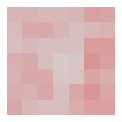

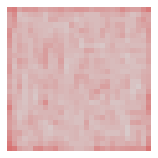

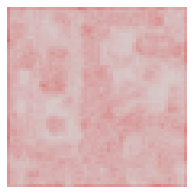

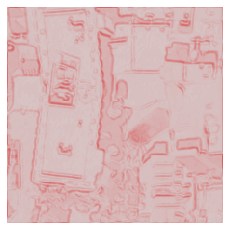

In [9]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0].cpu()).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [13]:
print(torchvision.version_info)

AttributeError: module 'torchvision' has no attribute 'version_info'